In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"mahajanbhushan","key":"88002547ce5a2790b7eda0352585b43c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset
!unzip -q deepglobe-road-extraction-dataset.zip -d dataset-folder

100% 3.79G/3.79G [00:32<00:00, 136MB/s]
100% 3.79G/3.79G [00:32<00:00, 126MB/s]


In [ ]:
import cv2
import numpy as np
from PIL import Image
from glob import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Input, Concatenate, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
def segment_image(sat_image, mask_image):
    _, binary_mask = cv2.threshold(mask_image, 128, 255, cv2.THRESH_BINARY)
    road_segmented = cv2.bitwise_and(sat_image, sat_image, mask=binary_mask)
    return road_segmented
def load_and_segment_images(image_files, mask_files, target_size=(128, 128)):
    segmented_images = []
    masks = []
    for img_file, mask_file in zip(image_files, mask_files):
        sat_image = cv2.imread(img_file, cv2.IMREAD_COLOR)
        sat_image = cv2.resize(sat_image, target_size)

        mask_image = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.resize(mask_image, target_size)

        segmented_img = segment_image(sat_image, mask_image)
        segmented_images.append(segmented_img)

        mask = Image.open(mask_file).resize(target_size)
        masks.append(np.array(mask))

    return segmented_images, masks

input_dir = "/content/dataset-folder/train"
sat_files = sorted(glob(os.path.join(input_dir, '*_sat.jpg')))
mask_files = sorted(glob(os.path.join(input_dir, '*_mask.png')))

segmented_images, masks = load_and_segment_images(sat_files, mask_files)

segmented_images = np.array(segmented_images).astype('float32') / 255.0
masks = np.array(masks).astype('float32') / 255.0
masks = np.expand_dims(masks, axis=-1)

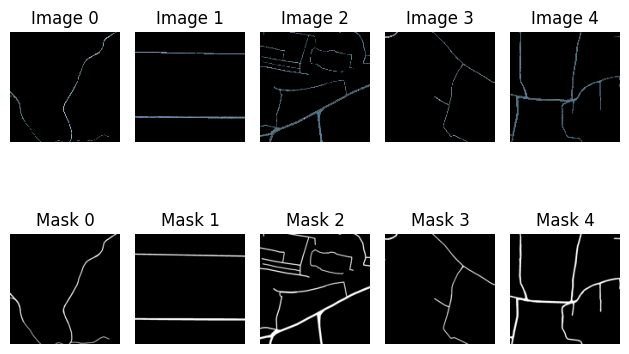

In [ ]:
import matplotlib.pyplot as plt
num_images = 5
for i in range(num_images):
      plt.subplot(2, num_images, i + 1)
      plt.imshow(segmented_images[i])
      plt.title("Image " + str(i))
      plt.axis('off')
      plt.subplot(2, num_images, num_images + i + 1)
      plt.imshow(masks[i, :, :, 0], cmap='gray')
      plt.title("Mask " + str(i))
      plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(segmented_images, masks, test_size=0.1, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=32)

In [ ]:
from keras.applications import ResNet50, VGG16
from keras.layers import Input, Concatenate, Conv2D, UpSampling2D
from keras.models import Model
input_tensor = Input(shape=(128, 128, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_features = resnet_model(input_tensor)
vgg_features = vgg_model(input_tensor)
merged_features = Concatenate()([resnet_features, vgg_features])
x = Conv2D(64, (3, 3), activation='relu', padding='same')(merged_features)
output = UpSampling2D(size=(32, 32))(x)
output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(output)

fusion_model = Model(inputs=input_tensor, outputs=output)
fusion_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history = fusion_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // 32,
    epochs=10
)

Epoch 1/10
176/176 [==============================] - 92s 316ms/step - loss: 0.2250 - accuracy: 0.9194 - val_loss: 0.6298 - val_accuracy: 0.9187
Epoch 2/10
176/176 [==============================] - 50s 286ms/step - loss: 0.1418 - accuracy: 0.9199 - val_loss: 0.6476 - val_accuracy: 0.9187
Epoch 3/10
176/176 [==============================] - 51s 287ms/step - loss: 0.1410 - accuracy: 0.9199 - val_loss: 0.5100 - val_accuracy: 0.9187
Epoch 4/10
176/176 [==============================] - 50s 286ms/step - loss: 0.1412 - accuracy: 0.9199 - val_loss: 0.2326 - val_accuracy: 0.9187
Epoch 5/10
176/176 [==============================] - 50s 287ms/step - loss: 0.1409 - accuracy: 0.9199 - val_loss: 0.1515 - val_accuracy: 0.9187
Epoch 6/10
176/176 [==============================] - 50s 286ms/step - loss: 0.1406 - accuracy: 0.9199 - val_loss: 0.1448 - val_accuracy: 0.9187
Epoch 7/10
176/176 [==============================] - 50s 286ms/step - loss: 0.1406 - accuracy: 0.9199 - val_loss: 0.1427 - val_ac

In [ ]:
import pickle

# save the iris classification model as a pickle file
fusion_model_segmentation_file = "/content/drive/MyDrive/fusion_model_segmentation_file.pkl"
with open(fusion_model_segmentation_file, 'wb') as file:
    pickle.dump(fusion_model, file)

In [ ]:
import pickle

# Save the history object to a file
with open('/content/fusion_model_segmentation_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved!")

Training history saved!


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    # Decoder
    decoder6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    decoder6 = concatenate([decoder6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(decoder6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    decoder7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    decoder7 = concatenate([decoder7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(decoder7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    decoder8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    decoder8 = concatenate([decoder8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(decoder8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    decoder9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    decoder9 = concatenate([decoder9, conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(decoder9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
unet_model = unet()
unet_model.summary()

In [ ]:
# Fit the model
history1 = unet_model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_valid) // 32,
    epochs=10
)

Epoch 1/10
175/175 [==============================] - 102s 500ms/step - loss: 0.1095 - accuracy: 0.9241 - val_loss: 0.0404 - val_accuracy: 0.9299
Epoch 2/10
175/175 [==============================] - 85s 484ms/step - loss: 0.0392 - accuracy: 0.9304 - val_loss: 0.0386 - val_accuracy: 0.9292
Epoch 3/10
175/175 [==============================] - 85s 485ms/step - loss: 0.0378 - accuracy: 0.9303 - val_loss: 0.0375 - val_accuracy: 0.9296
Epoch 4/10
175/175 [==============================] - 85s 485ms/step - loss: 0.0370 - accuracy: 0.9304 - val_loss: 0.0370 - val_accuracy: 0.9294
Epoch 5/10
175/175 [==============================] - 85s 485ms/step - loss: 0.0366 - accuracy: 0.9302 - val_loss: 0.0367 - val_accuracy: 0.9293
Epoch 6/10
175/175 [==============================] - 85s 484ms/step - loss: 0.0361 - accuracy: 0.9304 - val_loss: 0.0362 - val_accuracy: 0.9298
Epoch 7/10
175/175 [==============================] - 85s 485ms/step - loss: 0.0359 - accuracy: 0.9304 - val_loss: 0.0361 - val_a

In [ ]:
import pickle
unet_model_segmentation_file = "/content/drive/MyDrive/unet_model_segmentation_file.pkl"
with open(unet_model_segmentation_file, 'wb') as file:
    pickle.dump(unet_model, file)

In [ ]:
import pickle
with open('/content/unet_model_segmentation_history.pkl', 'wb') as file:
    pickle.dump(history1.history, file)
print("Training history saved!")

Training history saved!
